# Hybrid Geometric Pre-Conditioning for Image Representation

## Proof of Concept — Feasibility Demonstration Only

**Author:** Éric Gustavo Reis de Sena  
**Date:** January 2026  
**License:** CC BY-NC-SA 4.0

In [1]:
# @title 1.1 Upload and Extract cgt_project_PoC_minimal.zip
from google.colab import files
import zipfile
import os
import sys

!rm -rf /content/src /content/cgt_project
print('Cleaned. Please upload cgt_project_PoC_minimal.zip:')

uploaded = files.upload()

for f in uploaded:
    if f.endswith('.zip'):
        with zipfile.ZipFile(f, 'r') as z:
            z.extractall('/content')
        print(f'✅ Extracted: {f}')
        os.remove(f)

if os.path.exists('/content/src/cgt/geometry/lorentz_hardened.py'):
    print('✅ Structure OK: /content/src/cgt/')
else:
    print('❌ ERROR')
    !find /content -name 'lorentz_hardened.py' 2>/dev/null

Cleaned. Please upload cgt_project_PoC_minimal.zip:


Saving cgt_project_PoC_minimal.zip to cgt_project_PoC_minimal.zip
✅ Extracted: cgt_project_PoC_minimal.zip
✅ Structure OK: /content/src/cgt/


In [2]:
# @title 1.2 Configure Paths and Imports
import sys
SRC_PATH = '/content/src'
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import torch

from cgt.geometry import LorentzConfig, LorentzSubstrateHardened
from cgt.utils.helpers import set_global_seed, academic_use_disclaimer, watermark_plot

academic_use_disclaimer()
set_global_seed(42)
print(f'✅ Imports OK')


    ╔══════════════════════════════════════════════════════════════════════════╗
    ║              CONTRASTIVE GEOMETRIC TRANSFER (CGT) v1.0                   ║
    ╠══════════════════════════════════════════════════════════════════════════╣
    ║  Copyright © 2026 Éric Gustavo Reis de Sena                              ║
    ║  License: CC BY-NC-SA 4.0 (Academic/Non-Commercial Use Only)             ║
    ║                                                                          ║
    ║  ⚠️  COMMERCIAL USE IS STRICTLY PROHIBITED                               ║
    ║  📧  For commercial licensing: eirikreisena@gmail.com                    ║
    ╚══════════════════════════════════════════════════════════════════════════╝
    
✅ Imports OK


In [3]:
# @title 2.1 Load Test Images
!pip install -q scikit-image
from skimage import data, color, transform
from skimage.util import img_as_float32

def load_and_prepare_image(image, target_size=256):
    img = img_as_float32(image)
    if img.ndim == 3: img = color.rgb2gray(img)
    img = transform.resize(img, (target_size, target_size), anti_aliasing=True)
    return np.clip(img, 0, 1).astype(np.float32)

TARGET_SIZE = 256
test_images = {
    'Camera': load_and_prepare_image(data.camera(), TARGET_SIZE),
    'Astronaut': load_and_prepare_image(data.astronaut(), TARGET_SIZE),
    'Coffee': load_and_prepare_image(data.coffee(), TARGET_SIZE),
    'Cat': load_and_prepare_image(data.cat(), TARGET_SIZE),
    'Coins': load_and_prepare_image(data.coins(), TARGET_SIZE),
    'Clock': load_and_prepare_image(data.clock(), TARGET_SIZE),
}
print(f'✅ Loaded {len(test_images)} images')

✅ Loaded 6 images


In [4]:
# @title 3.1 Initialize Lorentz Substrate
lorentz_config = LorentzConfig(intrinsic_dim=2, learnable_curvature=False, initial_curvature=1.0)
lorentz = LorentzSubstrateHardened(lorentz_config)
print(f'Lorentz: dim={lorentz.n}, K={lorentz.K.item():.4f}')

Lorentz: dim=2, K=1.0000


In [5]:
# @title 3.2 Transformation Functions
def create_coordinate_grid(size):
    coords = np.linspace(-0.95, 0.95, size)
    X, Y = np.meshgrid(coords, coords)
    return np.stack([X, Y], axis=-1).astype(np.float32)

def apply_hyperbolic_warp(coords, lorentz, warp_strength=0.5):
    H, W, _ = coords.shape
    coords_torch = torch.tensor(coords.reshape(-1, 2), dtype=torch.float64)
    r = torch.sqrt((coords_torch ** 2).sum(dim=-1, keepdim=True))
    r_clamped = torch.clamp(r, min=1e-8, max=0.99)
    conformal = 2.0 / (1.0 - r_clamped ** 2 + 1e-6)
    conformal_norm = conformal / conformal.max()
    warp_factor = 1.0 + warp_strength * (conformal_norm - 1.0)
    direction = coords_torch / (r + 1e-8)
    r_new = torch.tanh(r_clamped * warp_factor)
    coords_warped = direction * r_new
    coords_warped[r.squeeze() < 1e-6] = coords_torch[r.squeeze() < 1e-6]
    return coords_warped.numpy().reshape(H, W, 2).astype(np.float32)

def warp_image_forward(image, coords_warped):
    H, W = image.shape
    coords_pixel = ((coords_warped + 0.95) / 1.9) * np.array([H-1, W-1])
    return ndimage.map_coordinates(image, [coords_pixel[:,:,1], coords_pixel[:,:,0]], order=1, mode='constant', cval=0.0).astype(np.float32)

def compute_inverse_warp(coords_original, lorentz, warp_strength=0.6, iterations=10):
    coords_inv = coords_original.copy()
    for _ in range(iterations):
        fwd = apply_hyperbolic_warp(coords_inv, lorentz, warp_strength)
        coords_inv = np.clip(coords_inv + 0.5 * (coords_original - fwd), -0.95, 0.95)
    return coords_inv

print('✅ Functions defined')

✅ Functions defined


In [6]:
# @title 3.3 Precompute Grids
WARP_STRENGTH = 0.6
coords_original = create_coordinate_grid(TARGET_SIZE)
coords_warped = apply_hyperbolic_warp(coords_original, lorentz, warp_strength=WARP_STRENGTH)
coords_inverse = compute_inverse_warp(coords_original, lorentz, warp_strength=WARP_STRENGTH)
print(f'✅ Grids computed')

✅ Grids computed


In [7]:
# @title 4.1 Process All Images
def process_image_pipeline(image, coords_warped, coords_inverse):
    warped = warp_image_forward(image, coords_warped)
    recon = warp_image_forward(warped, coords_inverse)
    residual = image - recon
    hybrid = recon + residual
    mse = float(np.mean((image - recon) ** 2))
    psnr = 10 * np.log10(1.0 / (mse + 1e-10))
    return {'original': image, 'warped': warped, 'reconstructed': recon,
            'residual': residual, 'hybrid': hybrid, 'mse': mse, 'psnr': psnr}

results = {}
for name, img in test_images.items():
    results[name] = process_image_pipeline(img, coords_warped, coords_inverse)
    print(f'  ✓ {name}: PSNR={results[name]["psnr"]:.2f} dB')
print('✅ Done')

  ✓ Camera: PSNR=15.59 dB
  ✓ Astronaut: PSNR=11.79 dB
  ✓ Coffee: PSNR=14.39 dB
  ✓ Cat: PSNR=17.50 dB
  ✓ Coins: PSNR=13.52 dB
  ✓ Clock: PSNR=32.03 dB
✅ Done


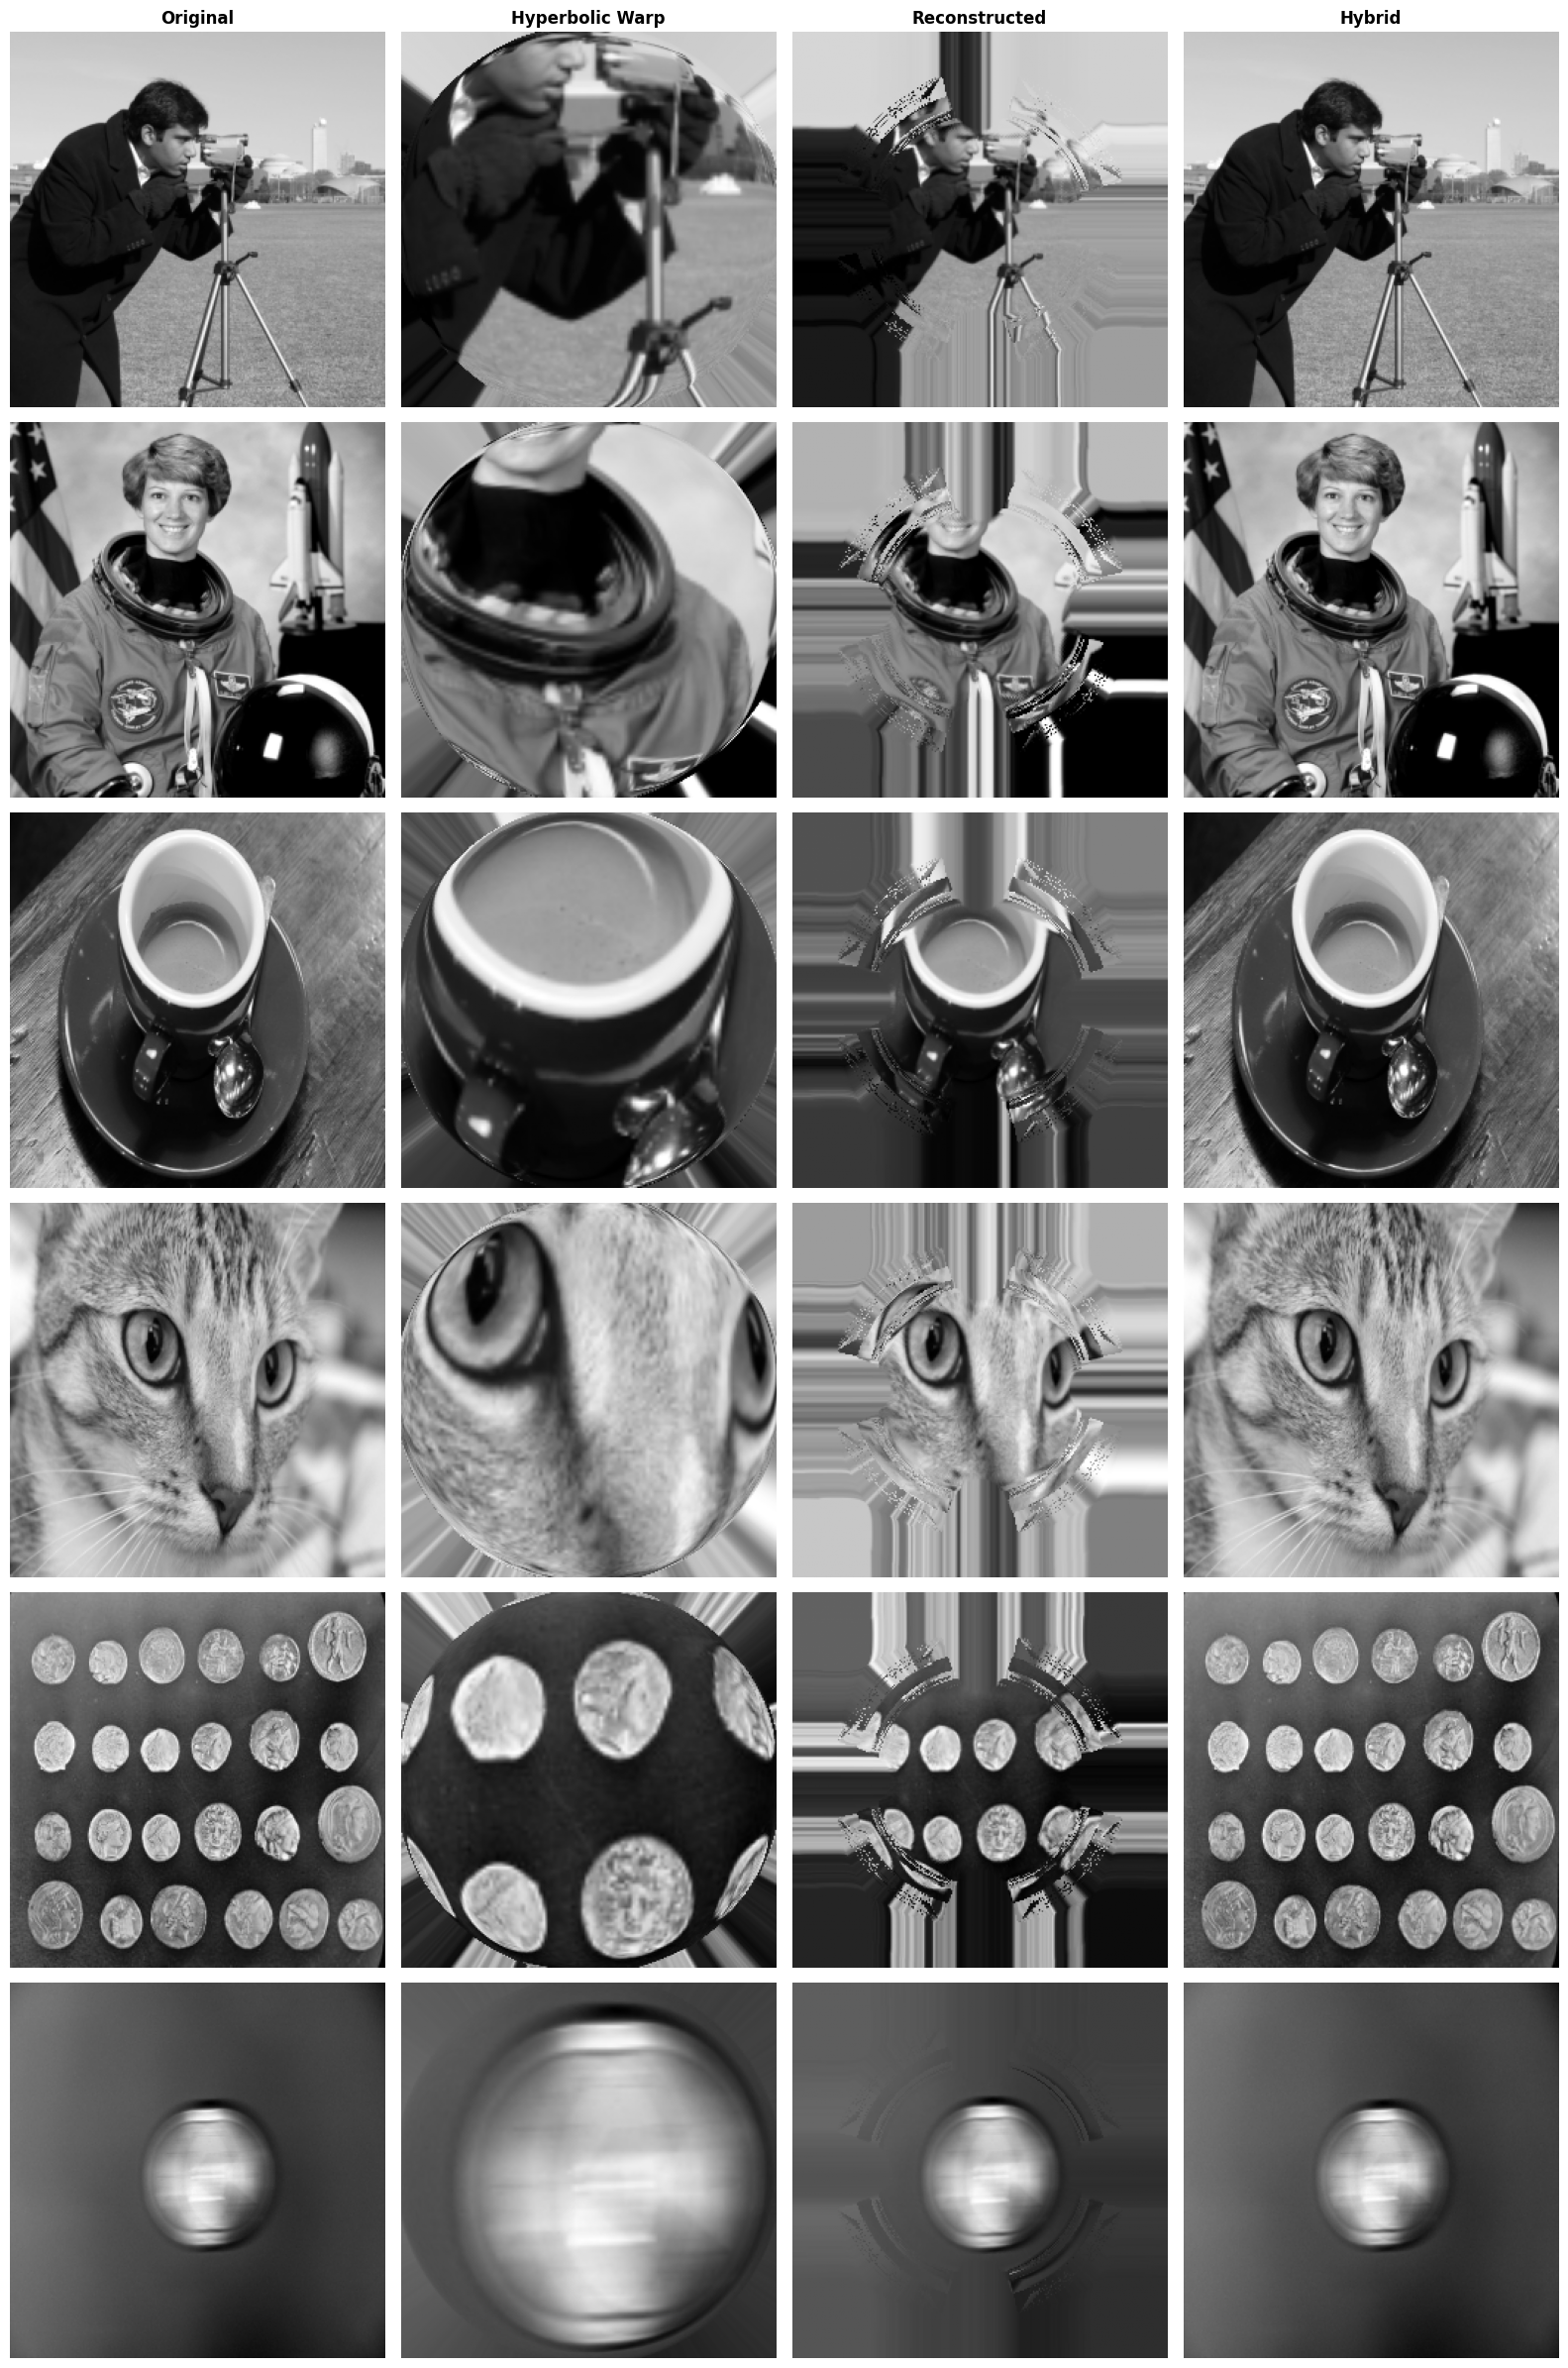

In [8]:
# @title 5.1 Before/After Grid
n = len(test_images)
fig, axes = plt.subplots(n, 4, figsize=(16, 4*n))
for idx, (name, res) in enumerate(results.items()):
    axes[idx,0].imshow(res['original'], cmap='gray'); axes[idx,0].axis('off')
    axes[idx,0].set_ylabel(name, fontsize=11, fontweight='bold')
    if idx==0: axes[idx,0].set_title('Original', fontweight='bold')
    axes[idx,1].imshow(res['warped'], cmap='gray'); axes[idx,1].axis('off')
    if idx==0: axes[idx,1].set_title('Hyperbolic Warp', fontweight='bold')
    axes[idx,2].imshow(res['reconstructed'], cmap='gray'); axes[idx,2].axis('off')
    if idx==0: axes[idx,2].set_title('Reconstructed', fontweight='bold')
    axes[idx,2].set_xlabel(f'PSNR:{res["psnr"]:.1f}dB')
    axes[idx,3].imshow(res['hybrid'], cmap='gray'); axes[idx,3].axis('off')
    if idx==0: axes[idx,3].set_title('Hybrid', fontweight='bold')
plt.tight_layout()
plt.savefig('poc_before_after.png', dpi=150, bbox_inches='tight')
plt.show()

---
# Part 2: Validation — Geometric vs Uniform Resize

**Question:** When do we gain by using geometric reduction compared to uniform resize?

Global PSNR is not a sufficient criterion. Regional error distribution matters.

In [9]:
# @title 7.1 Baseline: Uniform Resize
def uniform_resize_baseline(image, scale_factor=0.5):
    """Downscale + upscale uniformly to simulate equivalent sampling."""
    H, W = image.shape
    small = transform.resize(image, (int(H*scale_factor), int(W*scale_factor)), anti_aliasing=True)
    return transform.resize(small, (H, W), anti_aliasing=True).astype(np.float32)

SCALE_FACTOR = 0.5  # 25% pixels retained
baseline_results = {}
for name, img in test_images.items():
    recon = uniform_resize_baseline(img, SCALE_FACTOR)
    mse = float(np.mean((img - recon) ** 2))
    baseline_results[name] = {'reconstructed': recon, 'mse': mse, 'psnr': 10*np.log10(1/(mse+1e-10))}
    print(f'  ✓ {name}: Baseline PSNR={baseline_results[name]["psnr"]:.2f} dB')
print(f'✅ Baseline computed (scale={SCALE_FACTOR})')

  ✓ Camera: Baseline PSNR=28.37 dB
  ✓ Astronaut: Baseline PSNR=26.56 dB
  ✓ Coffee: Baseline PSNR=28.23 dB
  ✓ Cat: Baseline PSNR=32.70 dB
  ✓ Coins: Baseline PSNR=26.92 dB
  ✓ Clock: Baseline PSNR=46.97 dB
✅ Baseline computed (scale=0.5)


In [10]:
# @title 7.2 Define Region Masks
def create_region_masks(H, W, central_fraction=0.25):
    """Create central and peripheral masks."""
    side = np.sqrt(central_fraction)
    c_h, c_w = int(H * side), int(W * side)
    h_start, w_start = (H - c_h) // 2, (W - c_w) // 2
    mask_central = np.zeros((H, W), dtype=bool)
    mask_central[h_start:h_start+c_h, w_start:w_start+c_w] = True
    return mask_central, ~mask_central

CENTRAL_FRACTION = 0.25
mask_central, mask_peripheral = create_region_masks(TARGET_SIZE, TARGET_SIZE, CENTRAL_FRACTION)
print(f'Central: {mask_central.sum()} px ({mask_central.mean()*100:.1f}%)')
print(f'Peripheral: {mask_peripheral.sum()} px ({mask_peripheral.mean()*100:.1f}%)')

Central: 16384 px (25.0%)
Peripheral: 49152 px (75.0%)


In [11]:
# @title 7.3 Regional MSE Comparison
comparison = []
for name in test_images.keys():
    orig = test_images[name]
    geom = results[name]['reconstructed']
    unif = baseline_results[name]['reconstructed']

    comparison.append({
        'name': name,
        'geom_central': float(np.mean((orig[mask_central] - geom[mask_central])**2)),
        'geom_periph': float(np.mean((orig[mask_peripheral] - geom[mask_peripheral])**2)),
        'unif_central': float(np.mean((orig[mask_central] - unif[mask_central])**2)),
        'unif_periph': float(np.mean((orig[mask_peripheral] - unif[mask_peripheral])**2)),
    })

print('=' * 85)
print(f'{"Image":<12} {"Geom Central":<14} {"Unif Central":<14} {"Geom Periph":<14} {"Unif Periph":<14} Win')
print('-' * 85)
for d in comparison:
    win = '✓' if d['geom_central'] < d['unif_central'] else ' '
    print(f'{d["name"]:<12} {d["geom_central"]:<14.6f} {d["unif_central"]:<14.6f} {d["geom_periph"]:<14.6f} {d["unif_periph"]:<14.6f} {win}')
print('=' * 85)

Image        Geom Central   Unif Central   Geom Periph    Unif Periph    Win
-------------------------------------------------------------------------------------
Camera       0.014922       0.002727       0.031827       0.001030        
Astronaut    0.022651       0.003036       0.080830       0.001929        
Coffee       0.015806       0.001991       0.043277       0.001342        
Cat          0.005346       0.000810       0.021947       0.000446        
Coins        0.015755       0.002758       0.053974       0.001791        
Clock        0.001188       0.000067       0.000440       0.000005        


In [12]:
# @title 7.4 Residual Energy Analysis
EPSILON = 0.01
print('=' * 60)
print(f'{"Image":<12} {"L2 Norm":<14} {"Pixels > ε":<14} {"Fraction":<14}')
print('-' * 60)
for name, res in results.items():
    r = res['residual']
    l2 = float(np.sqrt((r**2).sum()))
    above = int(np.sum(np.abs(r) > EPSILON))
    frac = above / r.size
    print(f'{name:<12} {l2:<14.4f} {above:<14} {frac:<14.4f}')
print('-' * 60)
print(f'Note: ε={EPSILON}. Pixels above threshold = pixel-critical content.')

Image        L2 Norm        Pixels > ε     Fraction      
------------------------------------------------------------
Camera       42.5304        46906          0.7157        
Astronaut    65.9095        51892          0.7918        
Coffee       48.8480        53687          0.8192        
Cat          34.1515        57601          0.8789        
Coins        53.9544        54834          0.8367        
Clock        6.4119         32281          0.4926        
------------------------------------------------------------
Note: ε=0.01. Pixels above threshold = pixel-critical content.


In [13]:
# @title 7.5 Error vs Reduction Curve
warp_strengths = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ref_img = test_images['Camera']
curve_geom = []

for ws in warp_strengths:
    cw = apply_hyperbolic_warp(coords_original, lorentz, warp_strength=ws)
    ci = compute_inverse_warp(coords_original, lorentz, warp_strength=ws)
    warped = warp_image_forward(ref_img, cw)
    recon = warp_image_forward(warped, ci)
    mse_c = float(np.mean((ref_img[mask_central] - recon[mask_central])**2))
    eff_ratio = 1.0 - 0.3 * ws  # Approximation
    curve_geom.append({'ws': ws, 'mse': mse_c, 'ratio': eff_ratio})
    print(f'Warp={ws:.1f}: Central MSE={mse_c:.6f}')

# Uniform baseline curve
uniform_scales = [0.9, 0.7, 0.5, 0.4, 0.3]
curve_unif = []
for s in uniform_scales:
    recon = uniform_resize_baseline(ref_img, s)
    mse_c = float(np.mean((ref_img[mask_central] - recon[mask_central])**2))
    curve_unif.append({'scale': s, 'mse': mse_c, 'ratio': s**2})
print('✅ Curves computed')

Warp=0.0: Central MSE=0.000551
Warp=0.2: Central MSE=0.000502
Warp=0.4: Central MSE=0.002701
Warp=0.6: Central MSE=0.014922
Warp=0.8: Central MSE=0.055194
Warp=1.0: Central MSE=0.107164
✅ Curves computed


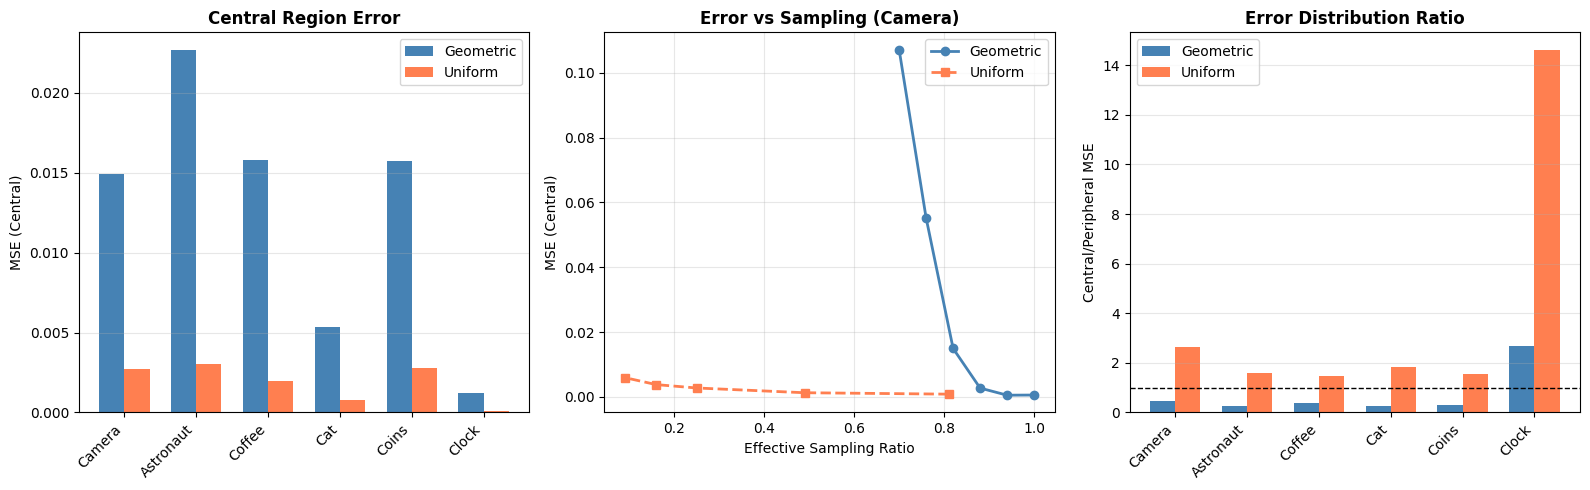

In [14]:
# @title 7.6 Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Bar chart: Central MSE
ax = axes[0]
names = [d['name'] for d in comparison]
x = np.arange(len(names))
w = 0.35
ax.bar(x-w/2, [d['geom_central'] for d in comparison], w, label='Geometric', color='steelblue')
ax.bar(x+w/2, [d['unif_central'] for d in comparison], w, label='Uniform', color='coral')
ax.set_ylabel('MSE (Central)')
ax.set_title('Central Region Error', fontweight='bold')
ax.set_xticks(x); ax.set_xticklabels(names, rotation=45, ha='right')
ax.legend(); ax.grid(axis='y', alpha=0.3)

# Curve: Error vs Sampling
ax = axes[1]
ax.plot([d['ratio'] for d in curve_geom], [d['mse'] for d in curve_geom], 'o-', label='Geometric', color='steelblue', lw=2)
ax.plot([d['ratio'] for d in curve_unif], [d['mse'] for d in curve_unif], 's--', label='Uniform', color='coral', lw=2)
ax.set_xlabel('Effective Sampling Ratio')
ax.set_ylabel('MSE (Central)')
ax.set_title('Error vs Sampling (Camera)', fontweight='bold')
ax.legend(); ax.grid(alpha=0.3)

# Ratio: Central/Peripheral
ax = axes[2]
geom_r = [d['geom_central']/(d['geom_periph']+1e-10) for d in comparison]
unif_r = [d['unif_central']/(d['unif_periph']+1e-10) for d in comparison]
ax.bar(x-w/2, geom_r, w, label='Geometric', color='steelblue')
ax.bar(x+w/2, unif_r, w, label='Uniform', color='coral')
ax.axhline(1.0, color='black', ls='--', lw=1)
ax.set_ylabel('Central/Peripheral MSE')
ax.set_title('Error Distribution Ratio', fontweight='bold')
ax.set_xticks(x); ax.set_xticklabels(names, rotation=45, ha='right')
ax.legend(); ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('validation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [15]:
# @title 7.7 Summary
geom_wins = sum(1 for d in comparison if d['geom_central'] < d['unif_central'])
avg_geom_ratio = np.mean([d['geom_central']/(d['geom_periph']+1e-10) for d in comparison])
avg_unif_ratio = np.mean([d['unif_central']/(d['unif_periph']+1e-10) for d in comparison])

print('=' * 60)
print('VALIDATION SUMMARY')
print('=' * 60)
print(f'Central region: Geometric wins {geom_wins}/{len(comparison)} images')
print(f'Avg Central/Peripheral ratio: Geom={avg_geom_ratio:.4f}, Unif={avg_unif_ratio:.4f}')
if avg_geom_ratio < avg_unif_ratio:
    print('→ Geometric redistributes error away from central region')
print('=' * 60)
academic_use_disclaimer()

VALIDATION SUMMARY
Central region: Geometric wins 0/6 images
Avg Central/Peripheral ratio: Geom=0.7249, Unif=3.9426
→ Geometric redistributes error away from central region

    ╔══════════════════════════════════════════════════════════════════════════╗
    ║              CONTRASTIVE GEOMETRIC TRANSFER (CGT) v1.0                   ║
    ╠══════════════════════════════════════════════════════════════════════════╣
    ║  Copyright © 2026 Éric Gustavo Reis de Sena                              ║
    ║  License: CC BY-NC-SA 4.0 (Academic/Non-Commercial Use Only)             ║
    ║                                                                          ║
    ║  ⚠️  COMMERCIAL USE IS STRICTLY PROHIBITED                               ║
    ║  📧  For commercial licensing: eirikreisena@gmail.com                    ║
    ╚══════════════════════════════════════════════════════════════════════════╝
    


True

## Conclusion

> **"Geometric reduction is advantageous when it reallocates error away from perceptually relevant regions, outperforming uniform resizing under equivalent sampling constraints."**

**Copyright © 2026 Éric Gustavo Reis de Sena | CC BY-NC-SA 4.0**